In [2]:
%pip install rasterio keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## Import Libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

In [4]:
project_path = './'
os.chdir(project_path)

In [5]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 40C2-C71B

 Directory of c:\Users\ngree\Desktop\my_uhi_detector

11/19/2024  12:52 PM    <DIR>          .
11/19/2024  10:41 AM    <DIR>          ..
11/11/2024  10:47 AM             6,148 .DS_Store
11/11/2024  01:25 PM                13 .gitignore
11/11/2024  12:21 PM    <DIR>          cache
11/17/2024  12:53 PM    <DIR>          data
11/19/2024  10:28 AM             1,131 get_buildings_geojson.py
11/19/2024  01:51 PM    <DIR>          models
11/11/2024  01:25 PM                77 requirements.txt
11/19/2024  10:28 AM             8,397 uhi_detector_kmeans.py
11/19/2024  03:34 PM           950,402 UHI_Detector_Noah.ipynb
11/19/2024  10:28 AM             6,397 UHI_Detector_prakriti.py
11/11/2024  01:04 PM             8,215 uhi_detector_rf.py
11/19/2024  10:28 AM             5,675 uhi_visualization_kmeans.py
11/18/2024  05:20 PM             9,970 uhi_visualization_rf.py
11/11/2024  01:04 PM    <DIR>          visualization
              10 F

In [6]:
# ## Step 1: Define Paths and Create Output Directories
data_dir = f"{project_path}/data/landsat/"
processed_dir = f"{project_path}/data/processed/normal"
results_dir = f"{project_path}/data/results/normal"

os.makedirs(processed_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# File paths for input and output

# red_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B4.TIF')
# nir_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B5.TIF')
# thermal_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B10.TIF')
# ndvi_output_path = os.path.join(processed_dir, 'ndvi.png')
# lst_output_path = os.path.join(processed_dir, 'lst.png')
# uhi_output_path = os.path.join(results_dir, 'uhi_detection.png')# ## Step 1: Define Paths and Create Output Directories
data_dir = 'data/landsat/'
processed_dir = 'data/processed/normal'
results_dir = 'data/results/normal'

os.makedirs(processed_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# File paths for input and output

red_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B4.TIF')
nir_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B5.TIF')
thermal_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B10.TIF')
ndvi_output_path = os.path.join(processed_dir, 'ndvi.tif')
lst_output_path = os.path.join(processed_dir, 'lst.tif')
uhi_output_path = os.path.join(results_dir, 'uhi_detection.tif')

ndvi_path = f"{project_path}/{ndvi_output_path}"
lst_path = f"{project_path}/{lst_output_path}"
kmeans_output_path = os.path.join(results_dir, 'uhi_detection_kmeans.tif')
unet_output_path = os.path.join(results_dir, 'uhi_detection_unet.tif')

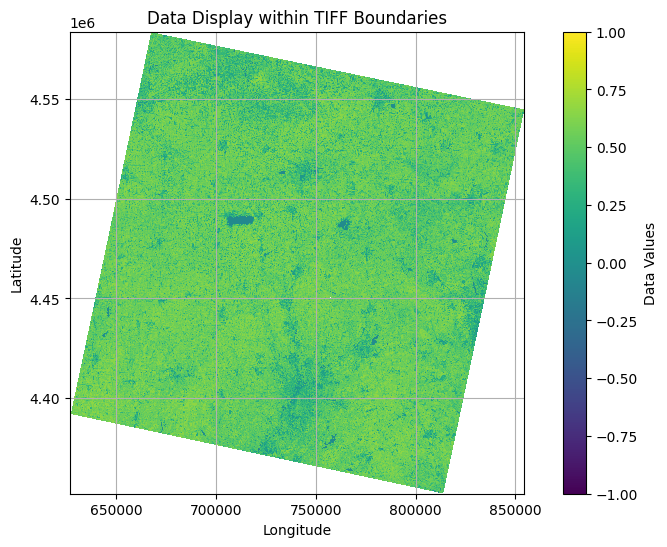

In [7]:
# import numpy as np
# import rasterio
# import matplotlib.pyplot as plt

# def calculate_ndvi(red_band_path, nir_band_path, output_path):
#     with rasterio.open(red_band_path) as red_src:
#         red = red_src.read(1).astype(float)  # Ensure float for division
#         profile = red_src.profile  # Get the metadata

#     with rasterio.open(nir_band_path) as nir_src:
#         nir = nir_src.read(1).astype(float)  # Ensure float for division

#     epsilon = 1e-10  # Small number to avoid division by zero
#     ndvi = (nir - red) / (nir + red + epsilon)

#     # Only clip values that are finite
#     ndvi = np.where(np.isfinite(ndvi), np.clip(ndvi, -1, 1), np.nan)

#     # Update the raster profile for single-band float32 output
#     profile.update(dtype=rasterio.float32, count=1)

#     # Save the NDVI image as a GeoTIFF
#     with rasterio.open(output_path, 'w', **profile) as dst:
#         dst.write(ndvi.astype(rasterio.float32), 1)

#     return ndvi

# # Define file paths
# red_band_path = red_band_path
# nir_band_path = nir_band_path
# ndvi_output_path = ndvi_output_path

# # Calculate NDVI
# ndvi = calculate_ndvi(red_band_path, nir_band_path, ndvi_output_path)

# # Display the NDVI
# plt.imshow(ndvi, cmap='RdYlGn')
# plt.title('NDVI Map')
# plt.colorbar()
# plt.show()



import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tiff_path=nir_band_path

def plot_tiff_within_boundaries(tiff_path):
    with rasterio.open(tiff_path) as src:
        data = src.read(1)  # Read the first band
        # Mask out values that are no-data in the dataset
        data[data == src.nodata] = np.nan  # Assuming the nodata value is set in the TIFF
        # Get the geographic bounds
        bounds = src.bounds
        min_x, min_y, max_x, max_y = bounds.left, bounds.bottom, bounds.right, bounds.top

    # Create a custom colormap that sets 'bad' (NaN) values to a specific color, e.g., transparent or white
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')  # Setting NaN values to white for visibility

    plt.figure(figsize=(10, 6))
    plt.imshow(data, cmap=cmap, interpolation='none', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar(label='Data Values')
    plt.title('Data Display within TIFF Boundaries')
    plt.xlim([min_x, max_x])
    plt.ylim([min_y, max_y])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Path to your TIFF file
tiff_path = ndvi_output_path
plot_tiff_within_boundaries(tiff_path)




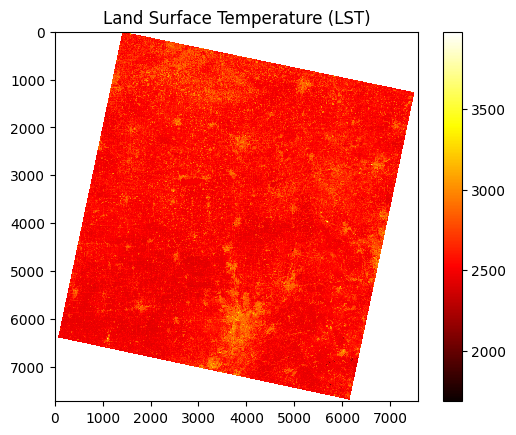

In [8]:
# # ## Step 3: Calculate Land Surface Temperature (LST)

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def calculate_lst(thermal_band_path, output_path):
    with rasterio.open(thermal_band_path) as thermal_src:
        thermal = thermal_src.read(1).astype(float) * 0.1  # Convert to Kelvin assuming scale factor of 0.1
        profile = thermal_src.profile

    # Handle no data values properly: assume no data values are set in the TIFF metadata
    nodata = thermal_src.nodata
    if nodata is not None:
        thermal[thermal == nodata] = np.nan  # Convert nodata values to NaN

    # Convert LST to Celsius, ensuring no data remains as NaN
    lst = np.where(np.isfinite(thermal), thermal - 273.15, np.nan)

    # Update the profile for saving the GeoTIFF
    profile.update(dtype=rasterio.float32, count=1)

    # Save LST to GeoTIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(lst.astype(rasterio.float32), 1)

    return lst

# Define file paths
thermal_band_path = thermal_band_path
lst_output_path = lst_output_path
# Calculate LST
lst = calculate_lst(thermal_band_path, lst_output_path)

# Create a custom colormap that sets 'bad' (NaN) values to a specific color, e.g., transparent or white
cmap = plt.cm.hot
cmap.set_bad(color='white')  # Setting NaN values to white for visibility

# Display the LST
plt.imshow(lst, cmap=cmap, interpolation='none')
plt.title('Land Surface Temperature (LST)')
plt.colorbar()
plt.show()


In [9]:
print("LST shape:", lst.shape)


LST shape: (7721, 7591)


In [10]:
print(ndvi_output_path)
print(lst_output_path)

data/processed/normal\ndvi.tif
data/processed/normal\lst.tif


**Mask NaN Values**

In [11]:
# Function to read raster data with handling for no-data values
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(float)  # Read the first band and convert to float
        nodata = src.nodata  # Get the no-data value
        data[data == nodata] = np.nan  # Replace no-data values with NaN
    return data

In [12]:
ndvi = read_raster(ndvi_output_path)
lst = read_raster(lst_output_path)
# Function to create a UHI mask based on NDVI and LST thresholds
def create_uhi_mask(ndvi, lst, ndvi_threshold=0.2, lst_percentile=90):
    # Create a mask for urban heat islands
    hotspots = (ndvi < ndvi_threshold) & (lst > np.percentile(lst[~np.isnan(lst)], lst_percentile))
    return hotspots.astype(np.uint8)

mask_data = create_uhi_mask(ndvi, lst)

NDVI min: -1.0, NDVI max: 1.0
LST min: 1687.949951171875, LST max: 3979.25
LST 90th percentile threshold: 2742.64990234375


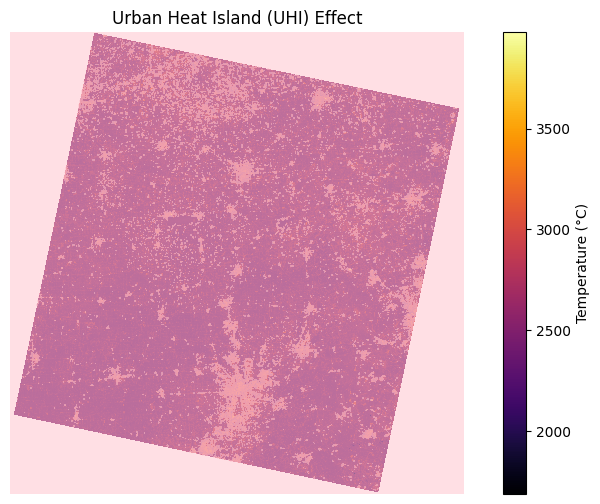

In [23]:
ndvi = read_raster(ndvi_path)
lst = read_raster(lst_path)

# Verify data ranges
print(f"NDVI min: {np.nanmin(ndvi)}, NDVI max: {np.nanmax(ndvi)}")
print(f"LST min: {np.nanmin(lst)}, LST max: {np.nanmax(lst)}")

# Adjust thresholds if necessary
ndvi_threshold = 0.2  # Adjust based on NDVI range
lst_threshold = np.percentile(lst[~np.isnan(lst)], 90)  # High LST threshold

print(f"LST 90th percentile threshold: {lst_threshold}")

hotspots = (ndvi < ndvi_threshold) & (lst > lst_threshold)

# Plotting the UHI effect
plt.figure(figsize=(10, 6))
plt.title('Urban Heat Island (UHI) Effect')

# Use an appropriate colormap
cmap = plt.get_cmap('inferno')
cmap.set_bad(color='white')

# Display the LST data
plt.imshow(lst, cmap=cmap, interpolation='none')
plt.colorbar(label='Temperature (°C)')

# Overlay filled contours for hotspots
plt.contourf(hotspots, colors='pink', alpha=0.5)

plt.axis('off')  # Hide axes for better visualization
plt.show()


In [80]:
# Function to create patches from NDVI, LST, and mask data
def create_patches(ndvi, lst, mask, patch_size=256):
    patches_ndvi = []
    patches_lst = []
    patches_mask = []
    coords = []
    h, w = ndvi.shape
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patches_ndvi.append(ndvi[i:i+patch_size, j:j+patch_size])
            patches_lst.append(lst[i:i+patch_size, j:j+patch_size])
            patches_mask.append(mask[i:i+patch_size, j:j+patch_size])
            coords.append((i, j))
    return np.array(patches_ndvi), np.array(patches_lst), np.array(patches_mask), coords

patches_ndvi, patches_lst, patches_mask, coords = create_patches(ndvi, lst, mask_data)

**KMEANS**

In [70]:
import os
import numpy as np
import rasterio
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def uhi_detection_kmeans(ndvi_path, lst_path, uhi_output_path_kmeans):
    ndvi = read_raster(ndvi_path)
    lst = read_raster(lst_path)

    # Stack NDVI and LST as features for clustering
    features = np.stack((ndvi.ravel(), lst.ravel()), axis=1)

    # Remove any rows with NaN values
    valid_mask = ~np.isnan(features).any(axis=1)
    features_valid = features[valid_mask]

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(features_valid)

    # Create the UHI map with NaNs where data was missing
    uhi_map = np.full(ndvi.shape, np.nan)
    uhi_map.ravel()[valid_mask] = labels

    # Save UHI map as a .tif file
    with rasterio.open(
        uhi_output_path_kmeans,
        'w',
        driver='GTiff',
        height=ndvi.shape[0],
        width=ndvi.shape[1],
        count=1,
        dtype=rasterio.float32,
        crs=rasterio.open(lst_path).crs,
        transform=rasterio.open(lst_path).transform
    ) as dst:
        dst.write(uhi_map.astype(rasterio.float32), 1)



uhi_detection_kmeans(ndvi_output_path, lst_output_path, kmeans_output_path)

**UNet**

In [72]:
import os
import numpy as np
import rasterio
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

os.makedirs('models', exist_ok=True)

# Function to build a UNet model
def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model





In [77]:
# Function to train a UNet model
model_save_path = 'models/unet_model.keras'

def train_unet_model(ndvi_data, lst_data, mask_data, model_save_path, input_shape=(256, 256, 2), epochs=5, batch_size=8):
    # Build the UNet model
    model = build_unet_model(input_shape)

    # Split data into training and validation sets
    X = np.stack((ndvi_data, lst_data), axis=-1)
    y = mask_data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define callbacks
    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ModelCheckpoint(model_save_path, save_best_only=True, verbose=1)
    ]

    # Train the model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

    return model

unet_model = train_unet_model(patches_ndvi, patches_lst, patches_mask, model_save_path, input_shape=(256, 256, 2))

Epoch 1/5


C:\Users\ngree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_36']. Received: the structure of inputs=*
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9537 - loss: 1.2207
Epoch 1: val_loss improved from inf to 0.65172, saving model to models/unet_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9540 - loss: 1.2157 - val_accuracy: 0.9874 - val_loss: 0.6517
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9875 - loss: 0.6420
Epoch 2: val_loss improved from 0.65172 to 0.61313, saving model to models/unet_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9875 - loss: 0.6418 - val_accuracy: 0.9874 - val_loss: 0.6131
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9898 - loss: 0.6036
Epoch 3: val_loss improved from 0.61313 to 0.57720, saving model to models/unet_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9898 - loss: 0.6035 - val_accuracy: 0.9874 - val_loss: 0.5772
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9870 - loss: 0.5688
Epoch 4: val_loss improved from 0.57720 to 0.54370, saving mod

**Plotting**

In [81]:
from tensorflow.keras.models import load_model

# Load the trained model
unet_model = load_model('models/unet_model.keras')

# Normalize and stack NDVI and LST patches
input_patches = np.stack((patches_ndvi, patches_lst), axis=-1).astype('float32') / 255

# Predict on each patch
predicted_patches = []
for i in range(input_patches.shape[0]):
    patch = np.expand_dims(input_patches[i], axis=0)  # Add batch dimension
    prediction = unet_model.predict(patch)[0]  # Predict on the patch
    predicted_patches.append((prediction[:, :, 0] > 0.5).astype(np.uint8))

predicted_patches = np.array(predicted_patches)

def reconstruct_full_image(patches, coords, image_shape, patch_size=256):
    full_image = np.zeros(image_shape, dtype=np.uint8)
    for patch, (i, j) in zip(patches, coords):
        full_image[i:i+patch_size, j:j+patch_size] = patch
    return full_image

# Reconstruct the full UHI map from predicted patches
uhi_map_full = reconstruct_full_image(predicted_patches, coords, ndvi.shape)

# Save the reconstructed UHI map as a .tif file
with rasterio.open(
    unet_output_path,
    'w',
    driver='GTiff',
    height=ndvi.shape[0],
    width=ndvi.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=rasterio.open(lst_output_path).crs,
    transform=rasterio.open(lst_output_path).transform
) as dst:
    dst.write(uhi_map_full, 1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [82]:
def visualize_uhi(uhi_mask_path, output_path, title='UHI Detection'):
    with rasterio.open(uhi_mask_path) as src:
        uhi_mask = src.read(1)
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.RdBu_r
    cmap.set_bad(color='white')
    masked_data = np.ma.masked_where(uhi_mask == -1, uhi_mask)
    im = plt.imshow(masked_data, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Non-UHI', 'UHI'])
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"UHI mask visualization saved to {output_path}")


visualize_uhi(kmeans_output_path, os.path.join(results_dir, 'uhi_visualization_kmeans.png'), title='UHI Detection using KMeans')
visualize_uhi(unet_output_path, os.path.join(results_dir, 'uhi_visualization_unet.png'), title='UHI Detection using UNet')

UHI mask visualization saved to data/results/normal\uhi_visualization_kmeans.png
UHI mask visualization saved to data/results/normal\uhi_visualization_unet.png


In [ ]:
# # Convert hotspots to float32 for saving in TIFF format
# hotspots = hotspots.astype('float32')

# # Set up profile for the new GeoTIFF
# # new_profile = lst.profile
# # new_profile.update(
# #     dtype=rasterio.float32,
# #     count=1,
# #     compress='lzw'
# # )

# with rasterio.open(lst_path) as lst_src:
#         lst = lst_src.read(1).astype(float) * 0.1  # Convert to Kelvin
#         new_profile = lst_src.profile


# # Path to save the new GeoTIFF
# output_tif_path = f"{project_path}/data/results/hotspots.tif"

# # Writing the data
# with rasterio.open(output_tif_path, 'w', **new_profile) as dst:
#     dst.write(hotspots, 1)

# print(f"Hotspots TIFF saved to {output_tif_path}")


In [ ]:
%pip install folium rasterio


In [ ]:
# import rasterio
# from rasterio.plot import show
# import folium

# # Path to your UHI TIFF file
# tif_path = f"{project_path}/data/results/hotspots.tif"

# # Open the TIFF file using rasterio
# with rasterio.open(tif_path) as src:
#     bounds = src.bounds
#     data = src.read(1)  # Read the first band for plotting

#     # Calculate the center of the map
#     lon = (bounds.left + bounds.right) / 2
#     lat = (bounds.bottom + bounds.top) / 2

# # Create a folium map at the calculated center
# m = folium.Map(location=[lat, lon], zoom_start=11)

# # Overlay the TIFF using folium's raster_layers
# folium.raster_layers.ImageOverlay(
#     image=data,
#     bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
#     colormap=lambda x: (x, 0, 1-x, x),  # You can customize the colormap as needed
#     name='UHI Effect'
# ).add_to(m)

# # Add layer control to toggle layers
# folium.LayerControl().add_to(m)

# # Display the map
# m.save('UHI_Map.html')
# m
